In [28]:
import xtrack as xt
import ruamel.yaml
import pickle
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import SplineTransformer, PolynomialFeatures
import matplotlib.pyplot as plt

# Initialize yaml reader
ryaml = ruamel.yaml.YAML()

In [ ]:
collider = xt.Multiline.from_json(
    "/afs/cern.ch/work/c/cdroin/private/example_DA_study/master_study/scans/dynamic_collapse_new/base_collider/xtrack_0000/collider/collider.json"
)
collider.build_trackers()

In [ ]:
# load dictionnary of elements from pickle
with open(
    "/afs/cern.ch/work/c/cdroin/private/example_DA_study/master_study/scans/dynamic_collapse_new/base_collider/xtrack_0000/gen_3/dynamic_configure.pkl",
    "rb",
) as fid:
    dic_elements = pickle.load(fid)

In [ ]:
l_xrange = []
d_element_attr_vals = {}
for key, d_beam in sorted(dic_elements.items()):
    l_xrange.append(key)
    for beam_temp, d_bb in d_beam.items():
        for type_bb, d_elements in d_bb.items():
            for element, d_attr in d_elements.items():
                if element not in d_element_attr_vals:
                    d_element_attr_vals[element] = {}

                for attr, val in d_attr.items():
                    if attr in d_element_attr_vals[element]:
                        d_element_attr_vals[element][attr].append(val)
                    else:
                        d_element_attr_vals[element][attr] = [val]

In [ ]:
d_element_attr_vals["bb_lr.l5b1_25"]["other_beam_shift_y"]

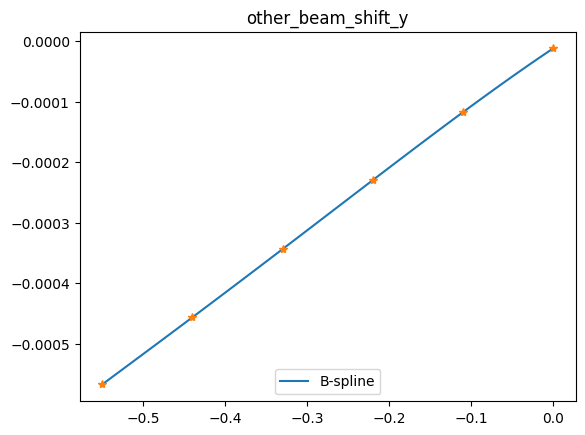

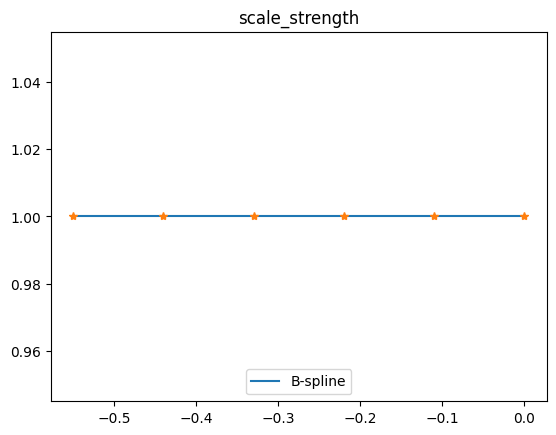

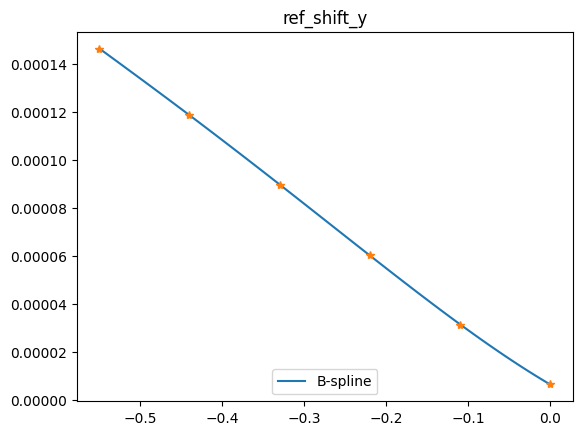

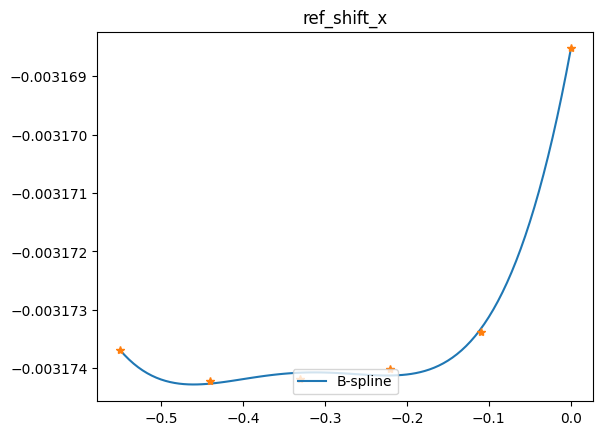

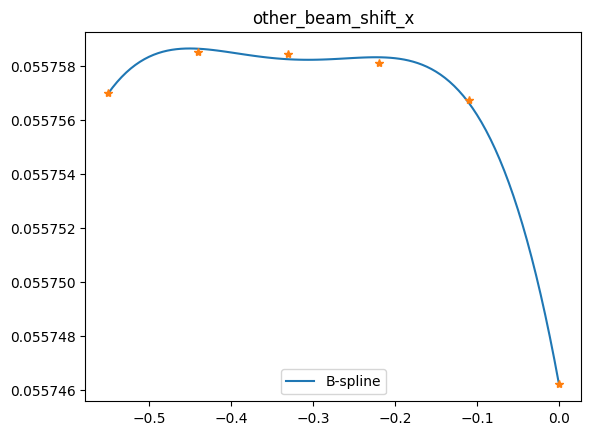

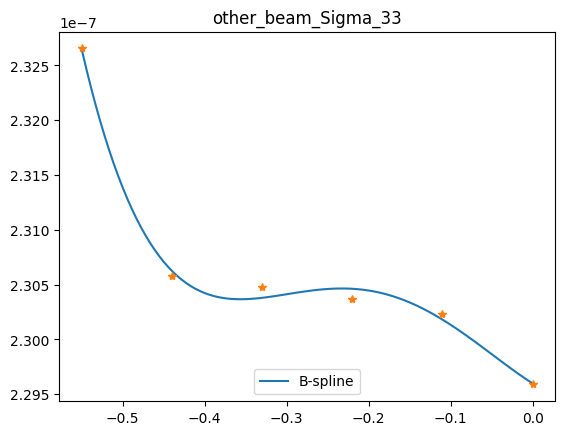

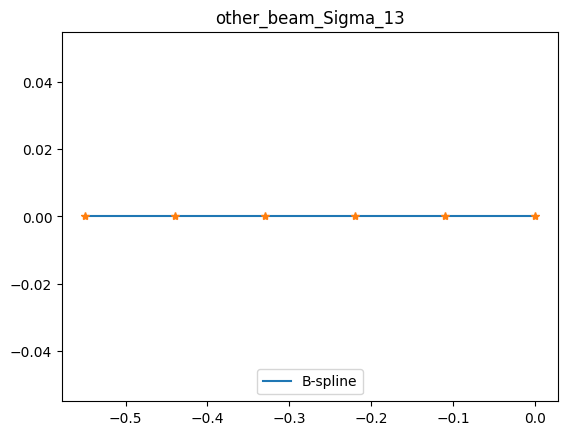

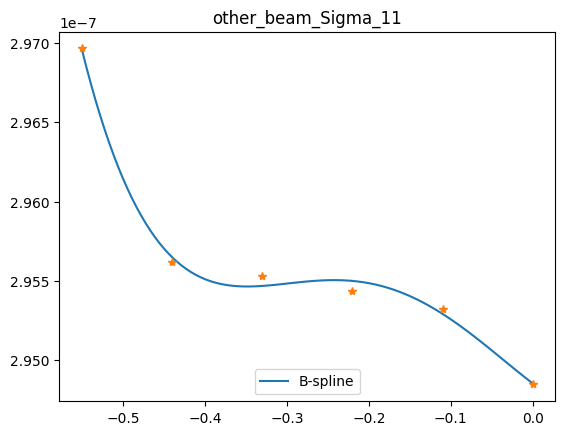

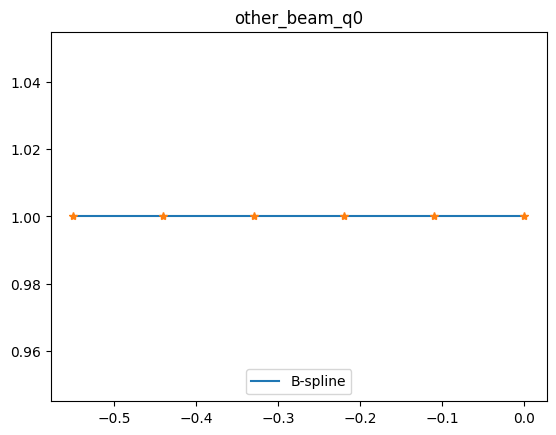

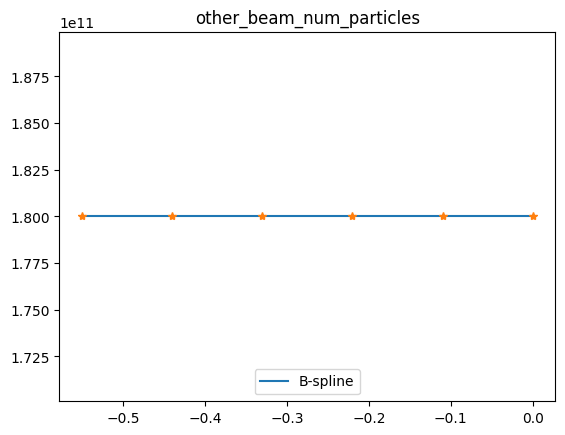

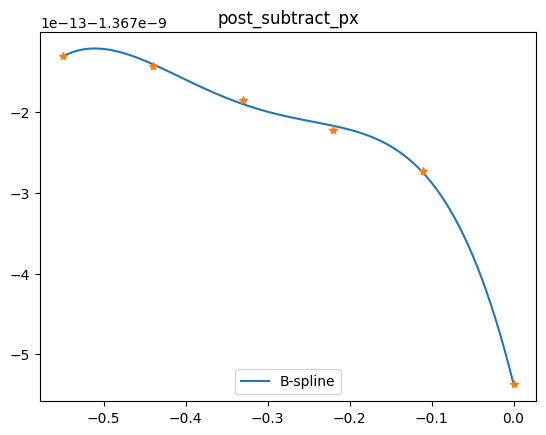

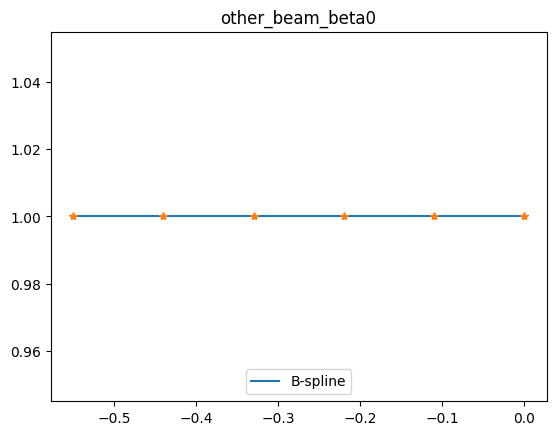

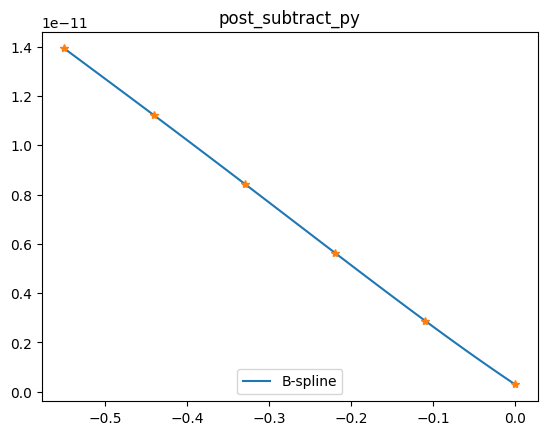

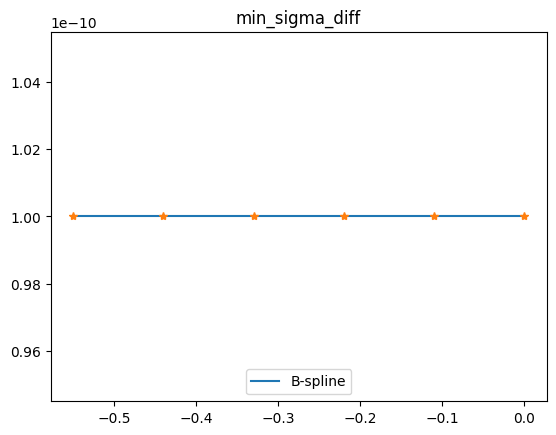

In [89]:
array_xrange = np.array(l_xrange)[:, np.newaxis]
array_xrange_to_plot = np.linspace(l_xrange[0], l_xrange[-1], 100, endpoint = True)[:, np.newaxis]
for attr in d_element_attr_vals['bb_lr.l5b1_25']:
    # B-spline with 4 + 3 - 1 = 6 basis functions
    model = make_pipeline(PolynomialFeatures(4), Ridge(alpha=1e-9)) # make_pipeline(SplineTransformer(n_knots=3, degree=5), Ridge(alpha=1e-9))
    model.fit(array_xrange, d_element_attr_vals['bb_lr.l5b1_25'][attr])

    fig, ax = plt.subplots()
    y_plot = model.predict(array_xrange_to_plot)
    ax.plot(array_xrange_to_plot, y_plot, label="B-spline")
    ax.plot(l_xrange, d_element_attr_vals['bb_lr.l5b1_25'][attr], '*')
    ax.legend(loc="lower center")
    ax.set_title(attr)
    #ax.set_ylim(-20, 10)
    plt.show()

In [94]:
model[:-1].get_feature_names_out()

array(['1', 'x0', 'x0^2', 'x0^3', 'x0^4'], dtype=object)

In [103]:
model[:-1].get_params()

{'memory': None,
 'steps': [('polynomialfeatures', PolynomialFeatures(degree=4))],
 'verbose': False,
 'polynomialfeatures': PolynomialFeatures(degree=4),
 'polynomialfeatures__degree': 4,
 'polynomialfeatures__include_bias': True,
 'polynomialfeatures__interaction_only': False,
 'polynomialfeatures__order': 'C'}

In [104]:
model[:-1].coef_

AttributeError: 'Pipeline' object has no attribute 'coef_'

In [112]:
model.steps[1][1].intercept_


1e-10

In [111]:
model.steps[1][1].coef_


array([0., 0., 0., 0., 0.])

In [ ]:
collider["lhcb1"]['bb_ho.l5b1_01']

In [ ]:
model.fit(array_xrange, d_element_attr_vals['bb_ho.l5b1_01']["post_subtract_zeta"])
y = model.predict(array_xrange)
y


In [ ]:
# B-spline with 4 + 3 - 1 = 6 basis functions
array_xrange = np.array(l_xrange)[:, np.newaxis]
array_xrange_to_plot = np.linspace(l_xrange[0], l_xrange[-1], 100, endpoint = True)[:, np.newaxis]
for attr in d_element_attr_vals['bb_ho.l5b1_01']:


    model = make_pipeline(SplineTransformer(n_knots=3, degree=5), Ridge(alpha=1e-9))
    model.fit(array_xrange, d_element_attr_vals['bb_ho.l5b1_01'][attr])

    fig, ax = plt.subplots()
    y_plot = model.predict(array_xrange_to_plot)
    ax.plot(array_xrange_to_plot, y_plot, label="B-spline")
    ax.plot(l_xrange, d_element_attr_vals['bb_ho.l5b1_01'][attr], '*')
    ax.legend(loc="lower center")
    ax.set_title(attr)
    #ax.set_ylim(-20, 10)
    plt.show()

In [20]:
model.predict([[-0.5]])[0,0]

3.6961856154584346e-10

In [48]:
import copy
import sklearn

In [82]:
def make_closure(model):
    return lambda x: np.squeeze(model.predict([[x]]))

array_xrange = np.array(l_xrange)[:, np.newaxis]
d_element_attr_regression = {'lhcb1' : {}, 'lhcb2' : {}}
for beam in d_element_attr_regression:
    d_element_attr_regression[beam] = {}
    for element in d_element_attr_vals:
        d_element_attr_regression[beam][element] = {}
        for attr in d_element_attr_vals[element]:
            d_element_attr_regression[beam][element][attr] = {}
            model = make_pipeline(SplineTransformer(n_knots=3, degree=5), Ridge(alpha=1e-9))
            model.fit(array_xrange, d_element_attr_vals[element][attr])
            d_element_attr_regression[beam][element][attr]['coeffs'] = [model.steps[1][1].intercept_]+list(model.steps[1][1].coef_)
            d_element_attr_regression[beam][element][attr]['fit'] = make_closure(model)
    


In [83]:
d_element_attr_regression['lhcb1']["bb_lr.l5b1_25"]["other_beam_shift_y"]['fit'](-0.3)

array(-0.00031275)

In [84]:
d_element_attr_regression['lhcb1']["bb_lr.l5b1_25"]["min_sigma_diff"]['fit'](-0.3)

array(1.e-10)

Now make a dynamic knob for each BB attribute